In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import astropy
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from regions import CircleSkyRegion, CirclePixelRegion
import astropy.constants as const
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
from scipy.integrate import simps
import aplpy


In [2]:
# read in data files
z2a = pd.read_csv('./resources/zprofile-2a.tsv', sep='\t', skiprows=6, header=None)
z2b = pd.read_csv('./resources/zprofile-2b.tsv', sep='\t', skiprows=6, header=None)
z2c = pd.read_csv('./resources/zprofile-2c.tsv', sep='\t', skiprows=6, header=None)

colnames = ['freq', 'intensity']
z2a.columns, z2a.name = colnames, '2a'
z2b.columns, z2b.name = colnames, '2b'
z2c.columns, z2c.name = colnames, '2c'

zprofs = [z2a, z2b, z2c]

In [3]:
# initialize 1d gaussian fit
g_init = models.Gaussian1D(amplitude=2e-4, mean=88.2, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g_fits = [None] * 3

In [ ]:
fig = plt.figure(figsize=(6, 15), dpi=100)
for i, j in enumerate(zprofs):
    ax = fig.add_subplot(1, 3, i+1)
    
    ax.step(j.freq, j.intensity)
    ax.set_title(f'Gal. {j.name}')
    
    ax.set_ylabel('Intensity (Jy/beam)')   
    ax.set_xlabel('Observed frequency (GHz)', labelpad=10)
    
    ax.set_ylim(-0.00025, .00065)
    
    ax.axhline(0, linestyle=":", c='black', alpha=0.5)

plt.subplots_adjust(hspace=.6)
plt.tight_layout()
plt.autoscale()
plt.savefig('figs/spectra_vert.png', bbox_inches = "tight")

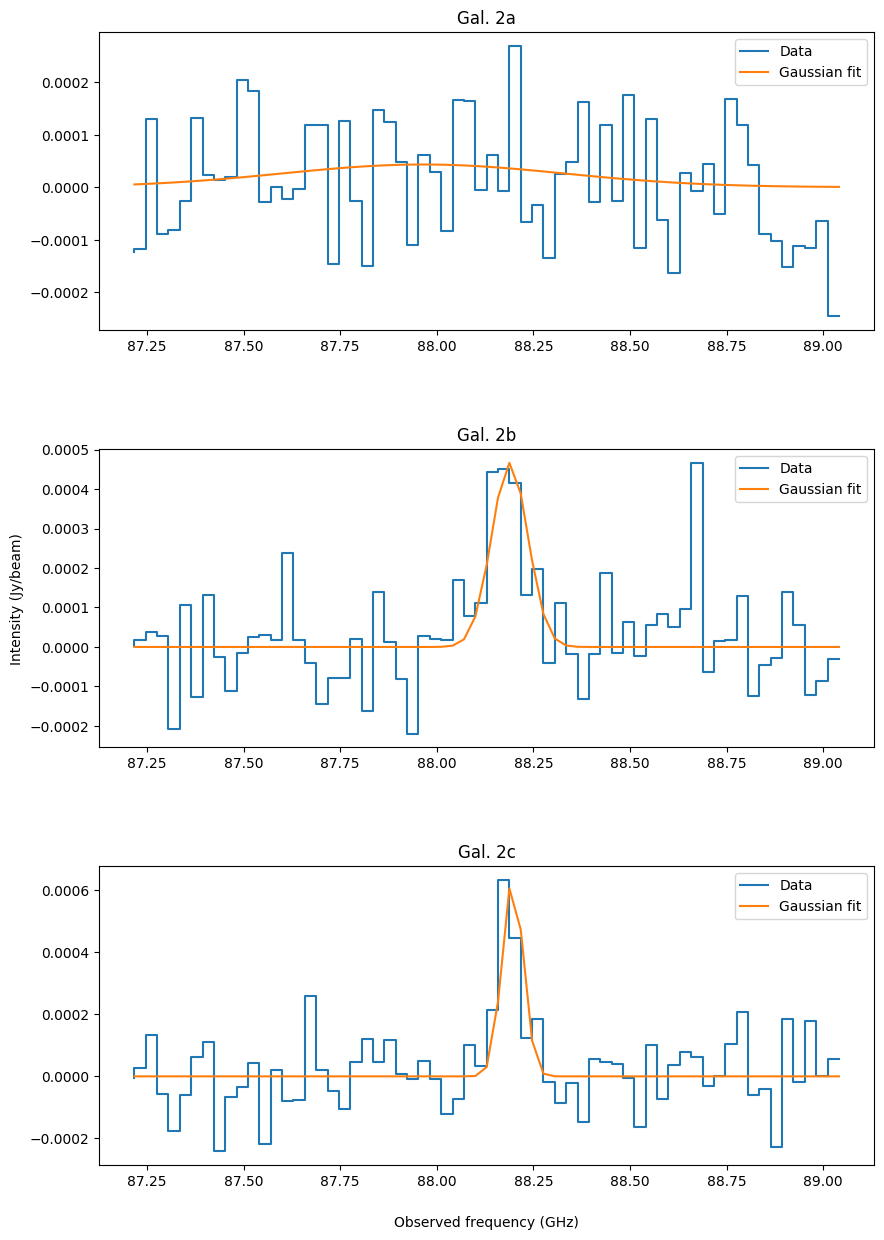

In [4]:
fig, ax = plt.subplots(3, figsize=(10, 15), dpi=100)
for i, j in enumerate(zprofs):
    g = fit_g(g_init, j.freq, j.intensity)
    g_fits[i] = g
    ax[i].step(j.freq, j.intensity, label='Data')
    ax[i].plot(j.freq, g(j.freq), label='Gaussian fit')
    ax[i].set_title(f'Gal. {j.name}')
    ax[i].legend()
    
plt.subplots_adjust(hspace=0.4)
ax[1].set_ylabel('Intensity (Jy/beam)')
ax[2].set_xlabel('Observed frequency (GHz)', labelpad=20);

plt.savefig('gaussian_fit.png')

In [5]:
for g in g_fits:
    print(g)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               mean             stddev      
    ---------------------- ----------------- ------------------
    4.3242787586700213e-05 87.96442293348686 0.3642692876320899
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude             mean              stddev       
    --------------------- ---------------- --------------------
    0.0004665800163583173 88.1888718691281 0.046952200186649654
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude              mean              stddev       
    --------------------- ----------------- --------------------
    0.0006358347176616632 88.19636046157565 0.027207947731166603


In [6]:
def z_from_freq(obs_freq, rest_freq):
    """ Given (arrays of) observed and rest frequencies, calculate redshift.
    """
    return (rest_freq / obs_freq) - 1

In [7]:
co_j32_freq = 345.8 # GHz
obs_freqs = np.array([g.mean.value for g in g_fits]) * u.GHz
obs_freqs

<Quantity [87.96442293, 88.18887187, 88.19636046] GHz>

In [8]:
redshifts = z_from_freq(obs_freqs.value, co_j32_freq)
redshifts

array([2.93113475, 2.92112965, 2.92079671])

In [9]:
@np.vectorize
def velocity_radio(obs_freq, rest_freq, z=0):
    """ Given (arrays of) observed and rest frequencies, calculate radio velocity in m/s.
    Optionally, shift the zero point of the velocity frame into the source by redshifting rest frequency. 
    """
    shifted_rest_freq = rest_freq / (z + 1)
    return (1 - obs_freq / shifted_rest_freq) * const.c.value


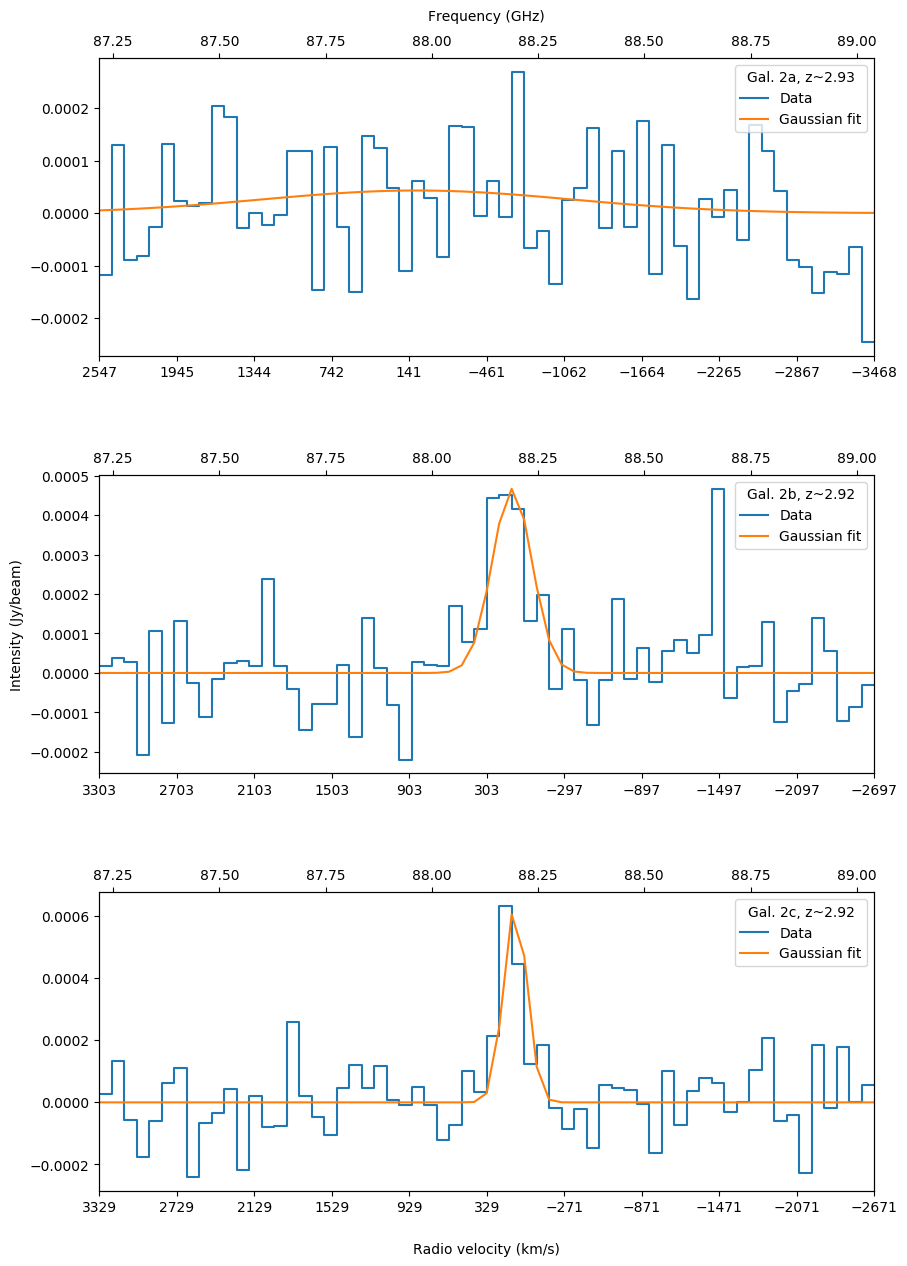

In [47]:
fig = plt.figure(figsize=(10, 15), dpi=100)
# plt.locator_params(nbins=10, axis='x')

for i, j in enumerate(zprofs):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_xlim(j.freq.values[0], j.freq.values[-1])
    
    vel_r = velocity_radio(j.freq, co_j32_freq, redshifts[i])
    xlabs_bottom = vel_r[::6] / 1000 # convert to km/s
    ax.step(j.freq, j.intensity, label='Data')
    ax.plot(j.freq, g_fits[i](j.freq), label='Gaussian fit')
    ax.legend(title=f'Gal. {j.name}, z~{redshifts[i]:.2f}', loc='upper right')

    
    # create second axis for redshift
    ax2 = ax.twiny()
    
    ax2.set_xlim(xlabs_bottom[0], xlabs_bottom[-1])
    plt.xticks(xlabs_bottom)
    
    # move frequency axis+label to top, redshift axis+label to bottom
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom')
    

    # kinda ugly...
    
    # set top x label
    if i == 0: 
        ax.set_xlabel('Frequency (GHz)', labelpad=10)
    
    # set y label
    if i == 1: 
        ax.set_ylabel('Intensity (Jy/beam)')
        
    # set bottom x label
    if i == 2: 
        ax2.set_xlabel('Radio velocity (km/s)', labelpad=20)
    
    
plt.subplots_adjust(hspace=0.4)
plt.savefig('redshift_axis_plot.png')


In [14]:
def RMSE(pred, target):
    """ Return root-mean-square error between two arrays
    """
    return np.sqrt(np.mean(np.square(pred - target)))

In [15]:
errors = [RMSE(g_fits[i](zprofs[i].freq), zprofs[i].intensity) for i in np.arange(len(zprofs))]
errors # kinda awkward... 2nd fit is supposedly worse than first fit.

[0.00010844131191218552, 0.00010939478628539257, 0.00010141759777772693]

In [16]:
s_co32_dvs = np.array([simps(y=g_fits[i](zprofs[i].freq), x=zprofs[i].freq) for i in np.arange(len(zprofs))]) * u.Jy * u.km / u.s
s_co32_dvs

<Quantity [3.86288022e-05, 5.49127274e-05, 4.36254186e-05] Jy km / s>

In [20]:
cosmo = FlatLambdaCDM(H0=70, Tcmb0=2.725, Om0=0.3) # default Tcmb0=0 gives very similar results
lum_dists = cosmo.luminosity_distance(redshifts)
lum_dists

<Quantity [24716.53479112, 24614.95650647, 24611.5772682 ] Mpc>

In [21]:
def line_luminosity(fluxes, lum_dists, zs, freq_obs):
    """ See first eqn. on Carilli and Walter 2013 p. 9
    """
    return const.c**2 / (2 * const.k_B) * fluxes * np.square(lum_dists) / (np.power(1+zs, 3) * np.square(freq_obs))


In [22]:
lco32 = line_luminosity(s_co32_dvs, lum_dists, redshifts, obs_freqs).to(u.K * u.km * u.pc**2 / u.s)
lco32

<Quantity [1633979.59008917, 2309607.11078946, 1834519.47145731] K km pc2 / s>

## WRONG UNITS ^ ??? cant convert??? i think the 3.25e7 has units on it which make it all work out. not specified in the carilli paper. 

## edit: check eqn 3 here. original form: 3.25e7 is actually  c^2/(2k). which has the units. http://adsabs.harvard.edu/full/1992ApJ...398L..29S 

In [23]:
lco10 = lco32 / .27
lco10

<Quantity [6051776.25958952, 8554100.41033131, 6794516.56095301] K km pc2 / s>

In [24]:
a_conversion_factor = 4.6 * u.M_sun / (u.K * u.km * u.pc**2 / u.s)
gas_mass = a_conversion_factor * lco10
gas_mass

<Quantity [27838170.79411178, 39348861.88752405, 31254776.18038383] solMass>

# i think this already takes into account the helium stuff. so it's total gas mass

In [25]:
amplifications = np.array([2.86, 8.1, 6.1])
delensed_gas_mass = gas_mass / amplifications # all the calculations scale linearly with the flux
delensed_gas_mass

<Quantity [9733626.15178734, 4857884.18364494, 5123733.80006292] solMass>

In [26]:
(delensed_gas_mass[2] - delensed_gas_mass[1]) / ((delensed_gas_mass[1] + delensed_gas_mass[2]) / 2)

<Quantity 0.05326784>

## consistent within 5% of each other

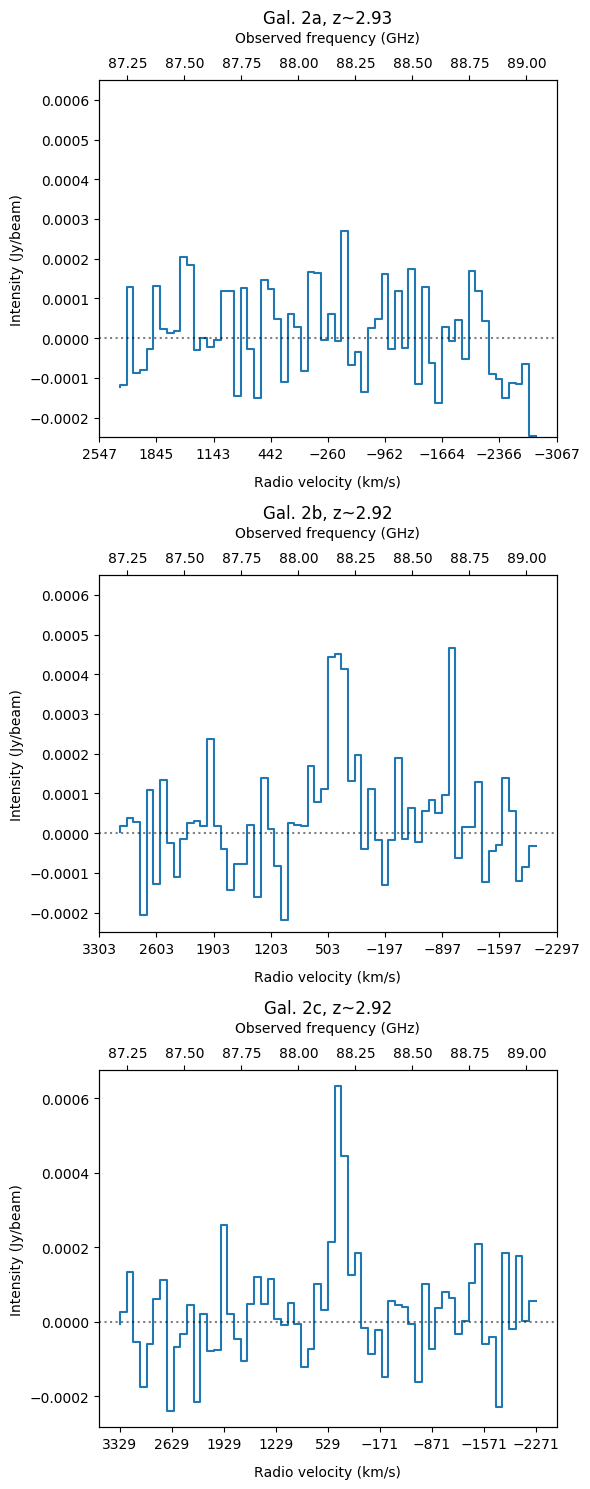

In [54]:
fig = plt.figure(figsize=(6, 15), dpi=100)
for i, j in enumerate(zprofs):
    ax = fig.add_subplot(3, 1, i+1)
    vel_r = velocity_radio(j.freq, co_j32_freq, redshifts[i])
    xlabs_bottom = vel_r[::7] / 1000
    
    ax.step(j.freq, j.intensity)
    ax.set_title(f'Gal. {j.name}, z~{redshifts[i]:.2f}')
    ax2 = ax.twiny()
    ax2.set_xlim(xlabs_bottom[0], xlabs_bottom[-1])
    plt.xticks(xlabs_bottom)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax2.xaxis.tick_bottom()
    ax2.xaxis.set_label_position('bottom')
    
    ax.set_ylabel('Intensity (Jy/beam)')   
    ax.set_xlabel('Observed frequency (GHz)', labelpad=10)
    ax2.set_xlabel('Radio velocity (km/s)', labelpad=10)
    
    ax.set_ylim(-0.00025, .00065)
    
    ax.axhline(0, linestyle=":", c='black', alpha=0.5)

plt.subplots_adjust(hspace=.6)
plt.tight_layout()
plt.autoscale()
plt.savefig('figs/spectra_vert.png', bbox_inches = "tight")

In [28]:
tab = Table.read('../../surp2020/resources/tab1.tex')
tab.add_index(tab.colnames)

c = (tab[['Galaxy ID']], 
     SkyCoord(ra=tab[['R.A. (J2000)']], dec=tab[['Dec. (J2000)']], unit=('hourangle', 'deg'), frame='icrs'))

hdu160 = fits.open('../../surp2020/resources/HST_images/j0454m0301-f160w_drz_sci.fits')[0]
wcs = WCS(hdu160.header)

xs, ys = c[1].to_pixel(wcs)
xdiff = np.abs(xs.min() - xs.max())
ydiff = np.abs(ys.min() - ys.max())
xmargin = 0.2
ymargin = 0.2
xlims = (xs.min() - xmargin * xdiff, xs.max() + xmargin * xdiff)
ylims = (ys.min() - ymargin * ydiff, ys.max() + ymargin * ydiff)

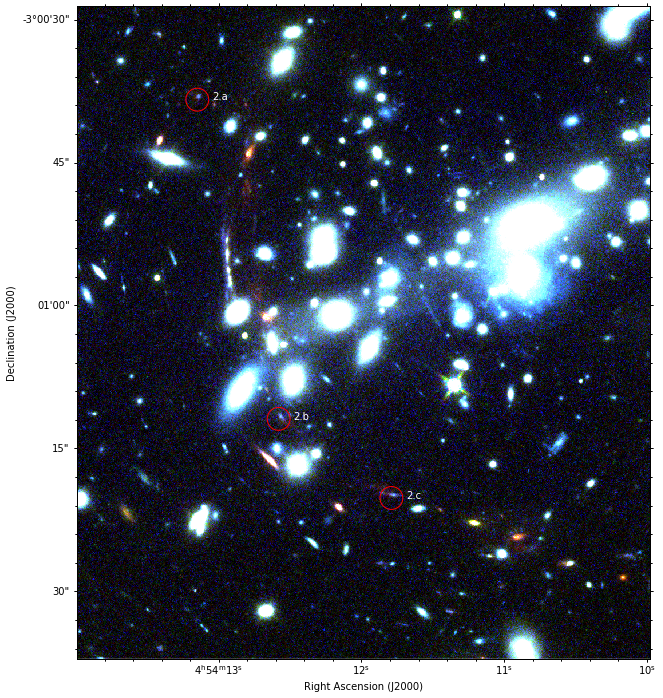

In [29]:
fig = plt.figure(figsize=(16, 12))
f1 = aplpy.FITSFigure('../../surp2020/resources/HST_images/j0454m0301-f160w_drz_sci.fits', figure=fig);

plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel('Right Ascension (J2000)')
plt.ylabel('Declination (J2000)')

f1.show_rgb('../../surp2020/output/new/99.85-99.85-99.00.png')

for i in range(3, 6):
    label, coord = c[0][i][0], c[1][i]
    pixel_region = f1.world2pixel(coord.ra, coord.dec)
    circ = patches.Circle(pixel_region, radius=20, linewidth=1, edgecolor='r', facecolor='none')
    f1.ax.add_patch(circ)
    f1.ax.annotate(label, 
                   xy=pixel_region, c='white', xycoords='data',
                   xytext=(15, 0), textcoords='offset points')
    
# plt.savefig('annotated.png')

In [30]:
sfr = 99 * u.M_sun / u.yr
sfe = sfr / delensed_gas_mass
sfe

<Quantity [1.01709269e-05, 2.03792425e-05, 1.93218469e-05] 1 / yr>